# Dense GNN implementation

In this exercise we are implementing a GNN from scratch using dense matrices.
Note that as the memory requirement of a dense matrix scales quadratically with the number of nodes in a graph, this limits us to datasets with only small graphs.

We will use the following dataset molHIV.

For the network we need a message-passing layer and pooling function.

1. Describe the datasets in your own words. Also talk about its features and statistical properties of the graphs and labels.
1. Implement the class GCNLayer to perform one round of message passing. You may use any variant of message passing here.
1. Implement a pooling layer like MeanPooling or SumPooling (or both).
1. Implement a one-hot-encoding of the atom type (this will positively affect classification performance)
1. Implement the model class GraphGCN that builds upon your GCNLayer and Pooling layer.
1. Create and train a GraphGCN model on MolHIV. As MOlHIV is highly imbalanced, it will make sense to adapt class weights in your loss function.

For the dataset molHIV we aim to reach something like 0.64 ROC (or higher). Note that for me the training was quite unstable, so several runs got stuck at 0.5.

Note: In this exercise, we use PyG only for utilities and not to build models. Feel free to edit/ignore any of the provided code as you see fit.

In [1]:
!pip install ogb torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.3 MB/s eta 0:00:00a 0:00:01


In [2]:
import torch
import torch_geometric as pyg
import numpy as np
from ogb.graphproppred import PygGraphPropPredDataset, Evaluator
import matplotlib.pyplot as plt
import os

from tqdm import tqdm

In [3]:
# find device
if torch.cuda.is_available():  # NVIDIA
    device = torch.device("cuda")
elif torch.backends.mps.is_available():  # apple silicon
    device = torch.device("mps")
else:
    device = torch.device("cpu")  # fallback
device

device(type='cuda')

In [4]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

set_seed()

Random seed set as 42


In [5]:
class GCNLayer(torch.nn.Module):
    def __init__(
        self,
        in_features: int,
        out_features: int,
        activation=torch.nn.functional.relu,
        skip_connection=False,
    ):
        super(GCNLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.activation = activation
        self.skip_connection = skip_connection
        self.weight = torch.nn.Parameter(torch.FloatTensor(in_features, out_features))
        torch.nn.init.kaiming_normal_(self.weight)

    def forward(self, H: torch.Tensor, adj: torch.Tensor):
        h_x = torch.bmm(adj, torch.matmul(H, self.weight))
        if self.skip_connection:
            return self.activation(h_x + H)
        return self.activation(h_x)

In [6]:
class MeanPooling(torch.nn.Module):
    def __init__(self, dim: int | tuple[int, ...]):
        super(MeanPooling, self).__init__()
        self.dim = dim

    def forward(self, H: torch.Tensor):
        return H.mean(dim=self.dim)

In [7]:
class SumPooling(torch.nn.Module):
    def __init__(self, dim: int | tuple[int, ...]):
        super(SumPooling, self).__init__()
        self.dim = dim

    def forward(self, H: torch.Tensor):
        return H.sum(dim=self.dim)

In [8]:
class GraphGCN(torch.nn.Module):
    def __init__(
        self,
        num_layers: int,
        in_features: int,
        hidden_features: int,
        out_features: int,
        pooling: MeanPooling | SumPooling,
        activation=torch.nn.functional.relu,
        skip_connection: bool = False,
        mlp_dropout_rate=0.1,
    ):
        super(GraphGCN, self).__init__()
        self.pooling = pooling
        self.activation = activation
        self.skip_connection = skip_connection
        self.layers = torch.nn.ModuleList(
            [
                GCNLayer(
                    in_features=in_features if i == 0 else hidden_features,
                    out_features=hidden_features,
                    activation=activation,
                    skip_connection=skip_connection if i != 0 else False,
                )
                for i in range(num_layers)
            ]
        )
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(hidden_features, hidden_features),
            torch.nn.ReLU(),
            torch.nn.Dropout(mlp_dropout_rate),
            torch.nn.Linear(hidden_features, out_features),
        )

    def forward(self, H_in: torch.Tensor, adj: torch.Tensor):
        H = H_in
        for i in range(len(self.layers)):
            H = self.layers[i](H, adj)
        H = self.pooling(H)
        return self.mlp(H)

## MolHIV

Pytorch Geometric stores its graphs in a sparse format using the variable edge_index.
We will thus need to create our own (torch) dataloader and extract the graphs into dense adjacency matrices.

In terms of model accuracy, it really helped me to add an "Atom encoding", i.e. a one-hot-encoding of the atoms instead of just having the atomic numbers appear in the first column of the node features.

In [24]:
class GraphDataSetVectorized(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self._dataset = dataset
        self._largest_graph_size = int(dataset.get_summary().num_nodes.max)
        self.targets = self._dataset.data.y
        self._max_num_atoms = 119
        self.atoms_to_index = {i: i - 1 for i in range(1, self._max_num_atoms + 1)}

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        graph = self._dataset[idx]

        # adjacency matrix
        A = torch.zeros((self._largest_graph_size, self._largest_graph_size))
        # symmetric
        A[graph.edge_index[0], graph.edge_index[1]] = 1
        A[graph.edge_index[1], graph.edge_index[0]] = 1
        # self loop
        A = A + torch.eye(self._largest_graph_size)
        # Degree matrix
        D = torch.diag(torch.sum(A, axis=1))
        # Normalized adjacency matrix
        d_inv_sqrt = torch.pow(D, -0.5)
        d_inv_sqrt[torch.isinf(d_inv_sqrt)] = 0.0
        A_normalized = d_inv_sqrt @ A @ d_inv_sqrt

        # node features
        H = torch.zeros((self._largest_graph_size, graph.x.shape[1]))
        H[: graph.x.shape[0]] = graph.x
        # one-hot encoding of atomic number
        atomic_no_feature = H[:, 0].long()
        atomic_no_feature = torch.nn.functional.one_hot(
            atomic_no_feature, num_classes=self._max_num_atoms
        )
        H = torch.cat([atomic_no_feature, H[:, 1:]], dim=-1)

        # target
        target = graph.y
        return A_normalized, H, target

    def num_features(self):
        return (
            self._dataset.num_features + self._max_num_atoms - 1
        )  # atomic number one-hot

    def compute_class_weights(self):
        class_counts = np.unique(self.targets, return_counts=True)[-1]
        frequencies = class_counts / len(self.targets)
        weights = np.round(1 / frequencies, 2)
        return torch.FloatTensor(weights / weights.sum()).to(device)

### Create Data Loaders for MolHIV

In [25]:
batch_size = 32

molHIV = PygGraphPropPredDataset(name="ogbg-molhiv", root="dataset/")
split_idx = molHIV.get_idx_split()

# vectorized dataset attempt
graph_dataset = GraphDataSetVectorized(molHIV)
atoms_to_index = graph_dataset.atoms_to_index

train_dataset = torch.utils.data.Subset(graph_dataset, split_idx["train"])
val_dataset = torch.utils.data.Subset(graph_dataset, split_idx["valid"])
test_dataset = torch.utils.data.Subset(graph_dataset, split_idx["test"])

# Create DataLoaders
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=4
)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=4
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=4
)

/opt/conda/lib/python3.10/site-packages/ogb/graphproppred/dataset_pyg.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data, self.slices = torch.load(self.processed

### Model and Training for MolHIV

The evaluation of MolHIV (and all other datasets from ogb) should happen through an Evaluator. You can also try playing around with learning rate schedulers.

In [26]:
evaluator = Evaluator(name='ogbg-molhiv')

def evaluate(model, loader):
    model.eval()

    y_true = list()
    y_pred = list()

    for adjacencies, features, targets in loader:
        adjacencies, features = adjacencies.to(device), features.to(device)

        with torch.no_grad():
            pred = model(features, adjacencies)
        y_pred.append(pred.argmax(dim=-1, keepdims=True))
        y_true.append(targets)

    y_true = torch.cat(y_true, dim=0).detach().cpu()
    y_pred = torch.cat(y_pred, dim=0).detach().cpu()

    input_dict = {"y_true": y_true.reshape(-1, 1), "y_pred": y_pred.reshape(-1,1)}

    return evaluator.eval(input_dict)['rocauc']

In [27]:
class EarlyStopping:
    def __init__(self, patience=20, min_delta=0):
        """
        Early stopping to prevent overfitting

        Args:
            patience: How many epochs to wait before stopping after last improvement
            min_delta: Minimum change to qualify as an improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_val = None
        self.should_stop = False

    def __call__(self, val_score):
        if self.best_val is None:
            self.best_val = val_score
        elif val_score <= self.best_val + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.should_stop = True
        else:
            self.best_val = val_score
            self.counter = 0

In [32]:
# training with add early stopping
def train_model(model, train_loader, val_loader, device, lr=1e-3, weight_decay=1e-4, num_epochs=50, patience=20):
    # optimizer and rate scheduler
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="max", factor=0.5, patience=10, verbose=True
    )

    # class weights and loss function
    class_weights = train_loader.dataset.dataset.compute_class_weights()
    loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)

    early_stopping = EarlyStopping(patience=patience)
    best_val_roc = 0
    best_model = None

    train_losses = []
    train_aucs = []
    val_aucs = []
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0

        for adjacencies, features, targets in train_loader:
            adjacencies, features, targets = (
                adjacencies.to(device),
                features.to(device),
                targets.to(device),
            )
            # Forward pass
            optimizer.zero_grad()
            logits = model(features, adjacencies)
            loss = loss_fn(logits, targets.squeeze())
            # Backward pass
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
        
        train_loss = train_loss / len(train_loader)
        train_losses.append(train_loss)

        # Evaluate on train and validation sets
        train_roc = evaluate(model, train_loader)
        val_roc = evaluate(model, val_loader)

        train_aucs.append(train_roc)
        val_aucs.append(val_roc)

        # Print metrics
        print(f'Epoch {epoch+1:03d} | Train Loss: {train_loss:.4f} | Train ROC: {train_roc:.4f} | Val ROC: {val_roc:.4f}')

        # Learning rate scheduling
        scheduler.step(val_roc)

        # Save best model and check early stopping
        if val_roc > best_val_roc:
            best_val_roc = val_roc
            best_model = model.state_dict()

        early_stopping(val_roc)
        if early_stopping.should_stop:
            print(f'Early stopping triggered at epoch {epoch+1}')
            break

    return best_model, train_losses, train_aucs, val_aucs

In [37]:
model = GraphGCN(
    num_layers=2,
    in_features=graph_dataset.num_features(),
    hidden_features=64,
    out_features=molHIV.num_classes,
    pooling=MeanPooling(dim=1),
    activation=torch.nn.functional.relu,
    skip_connection=True,
).to(device)

best_model, train_losses, train_aucs, val_aucs = train_model(model, train_loader, val_loader, device, num_epochs=50, patience=10)

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 001 | Train Loss: 0.6528 | Train ROC: 0.5941 | Val ROC: 0.6416
Epoch 002 | Train Loss: 0.6412 | Train ROC: 0.5975 | Val ROC: 0.6304
Epoch 003 | Train Loss: 0.6305 | Train ROC: 0.6045 | Val ROC: 0.6372
Epoch 004 | Train Loss: 0.6240 | Train ROC: 0.6133 | Val ROC: 0.6459
Epoch 005 | Train Loss: 0.6201 | Train ROC: 0.6183 | Val ROC: 0.6353
Epoch 006 | Train Loss: 0.6165 | Train ROC: 0.6269 | Val ROC: 0.6394
Epoch 007 | Train Loss: 0.6111 | Train ROC: 0.6190 | Val ROC: 0.6423
Epoch 008 | Train Loss: 0.6038 | Train ROC: 0.6262 | Val ROC: 0.6433
Epoch 009 | Train Loss: 0.6060 | Train ROC: 0.6122 | Val ROC: 0.5938
Epoch 010 | Train Loss: 0.6048 | Train ROC: 0.6229 | Val ROC: 0.6050
Epoch 011 | Train Loss: 0.6002 | Train ROC: 0.6304 | Val ROC: 0.6167
Epoch 012 | Train Loss: 0.5998 | Train ROC: 0.6288 | Val ROC: 0.6284
Epoch 013 | Train Loss: 0.5954 | Train ROC: 0.6330 | Val ROC: 0.6111
Epoch 014 | Train Loss: 0.5989 | Train ROC: 0.6314 | Val ROC: 0.5906
Early stopping triggered at epoch 

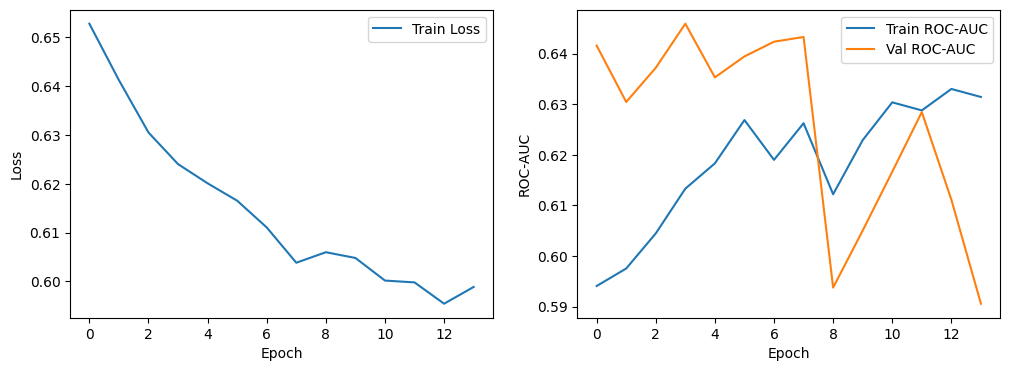

In [38]:
# Plot loss and ROC-AUC
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_aucs, label='Train ROC-AUC')
plt.plot(val_aucs, label='Val ROC-AUC')
plt.xlabel('Epoch')
plt.ylabel('ROC-AUC')
plt.legend()
plt.show()

In [39]:
# Evaluate on test set
test_rocauc = evaluate(model, test_loader)
print(f"Test ROC-AUC: {test_rocauc:.4f}")

Test ROC-AUC: 0.6513
